## Implementando os Simuladores para o Caso Exponencial

Descrição: Considere uma fila M/M/1, em que chegadas ocorrem segundo um fluxo Poisson com taxa 1 chegadas/segundo e serviços são tais que cada serviço é distribuído exponencialmente com média 1/2 segundo. Implemente dois simuladores.

- **Simulador 1** - A cada iteração, você amostra duas amostras de variáveis exponenciais com taxas $\lambda$ e $\mu$, uma correspondente ao tempo até a próxima chegada e outra correspondente ao tempo até o próximo serviço. Selecione a menor das amostras, atualize o tempo de simulação de acordo e continue até satisfazer o seu critério de parada.
- **Simulador 2** - Mantenha uma lista de eventos, que é uma lista de prioridades em que a prioridade é o tempo até o próximo evento, inicializada com 1 único evento, o instante da próxima chegada. A cada iteração, remova o elemento na cabeça da lista de eventos, trate-o, e siga em frente.

Simule a fila M/M/1 usando as duas abordagens acima, indicando que as respostas obtidas para tempo médio de espera dos clientes (com intervalos de confiança) são estatisticamente equivalentes.

- **Cenário 1:** ${\lambda = 1}$ e ${\mu = 2}$
- **Cenário 2:** ${\lambda = 2}$ e ${\mu = 4}$
- **Cenário 3:** ${\lambda = 1}$ e ${\mu = 4}$
- **Cenário 4:** ${\lambda = 1}$ e ${\mu = 2}$, mas serviço determinístico

In [2]:
import random
import heapq
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
def simulate1(arrival_rate, service_rate, max_steps=1000, determ_arrival=False, determ_service=False):
    total_arrivals = total_departures = total_waiting_time = simulation_time = queue_length = 0
    arrivals_queue = []

    gen_arrival = (lambda rate:1/rate) if determ_arrival else lambda rate:random.expovariate(rate)
    gen_service = (lambda rate:1/rate) if determ_service else lambda rate:random.expovariate(rate)

    for i in range(max_steps):
        sample_arrival = gen_arrival(arrival_rate)
        sample_departure = gen_service(service_rate)

        if queue_length == 0 or sample_arrival < sample_departure:
            # Arrival
            simulation_time += sample_arrival
            total_arrivals += 1
            queue_length += 1
            if queue_length > 1:
                arrivals_queue.append(simulation_time)
        else:
            # Departure
            simulation_time += sample_departure
            total_departures += 1
            queue_length -= 1
            if len(arrivals_queue) > 0:
                total_waiting_time += simulation_time - arrivals_queue.pop(0)

    average_waiting_time = total_waiting_time / total_departures
    average_clients_in_system = total_arrivals / simulation_time

    return {
        "average_waiting_time": average_waiting_time,
        "average_clients_in_system": average_clients_in_system
    }

In [4]:
def simulate2(arrival_rate, service_rate, max_steps=1000, determ_arrival=False, determ_service=False):
    simulation_time = total_arrivals = total_departures = total_waiting_time = 0
    events = []
    arrivals_queue = []

    gen_arrival = (lambda rate:1/rate) if determ_arrival else lambda rate:random.expovariate(rate)
    gen_service = (lambda rate:1/rate) if determ_service else lambda rate:random.expovariate(rate)

    heapq.heappush(events, (gen_arrival(arrival_rate), 'chegada'))

    while simulation_time < max_steps:
        next_event_time, event_type = heapq.heappop(events)
        
        simulation_time = next_event_time
        
        if event_type == 'chegada':
            #print("Arrival")
            total_arrivals += 1
            
            heapq.heappush(events, (simulation_time + gen_arrival(arrival_rate), 'chegada'))
            
            if total_arrivals - total_departures == 1:
                heapq.heappush(events, (simulation_time + gen_service(service_rate), 'saida'))
            if total_arrivals - total_departures > 1:
                arrivals_queue.append(simulation_time)
            
        else:
            #print("Departure")
            total_departures += 1

            if len(arrivals_queue) > 0:
                total_waiting_time += simulation_time - arrivals_queue.pop(0)
            
            if total_arrivals > total_departures:
                heapq.heappush(events, (simulation_time + gen_service(service_rate), 'saida'))
        
    average_waiting_time = total_waiting_time / (total_departures)
    average_clients_in_system = total_arrivals / simulation_time

    return {
        "average_waiting_time": average_waiting_time,
        "average_clients_in_system": average_clients_in_system
    }

In [5]:
def get_confidence_interval(avg_waiting_time):
    n = len(avg_waiting_time)
    mean = np.sum(avg_waiting_time)/n
    s = np.std(avg_waiting_time)
    min = mean - 1.96*s/math.sqrt(n)
    max = mean + 1.96*s/math.sqrt(n)
    return [min,max]

In [6]:
def make_plots(arrival_rate, service_rate, n_simulations, is_deterministic=False, simulation_function=simulate1):
  max_steps = [100, 1000, 10000]

  fig, axes = plt.subplots(3, 2, figsize=(10, 12))

  for i in range(len(max_steps)):
    average_waiting_times = [simulation_function(arrival_rate, service_rate, max_steps[i], determ_service=is_deterministic)["average_waiting_time"] for _ in range(n_simulations)]
    confidence_min, confidence_max = get_confidence_interval(average_waiting_times)
    print(f"Intervalo de Confiança (max_steps: {max_steps[i]}): [{confidence_min}, {confidence_max}]")

    if i == 0:
      ylim = max(average_waiting_times)

    # Histogram
    axes[i][0].hist(average_waiting_times, bins=30, edgecolor='black')
    axes[i][0].set_xlabel('Average Waiting Time')
    axes[i][0].set_ylabel('Frequency')
    axes[i][0].set_title(f'Histogram ({max_steps[i]} max_steps)')

    # Scatter Plot
    axes[i][1].scatter(range(1, n_simulations + 1), average_waiting_times, s=10)
    axes[i][1].set_xlabel('ith simulation')
    axes[i][1].set_ylabel('Average Waiting Time')
    axes[i][1].set_ylim(0, ylim)
    axes[i][1].set_title(f'Scatter Plot ({max_steps[i]} max_steps)')

    axes[i][0].grid(True)
    axes[i][1].grid(True)


  fig.tight_layout(pad=5.0)
  plt.show()

Intervalo de Confiança (max_steps: 100): [0.939046233682586, 1.022482165241758]
Intervalo de Confiança (max_steps: 1000): [1.1501650818300382, 1.1918741312238867]
Intervalo de Confiança (max_steps: 10000): [1.1932757755830699, 1.2059005790250426]


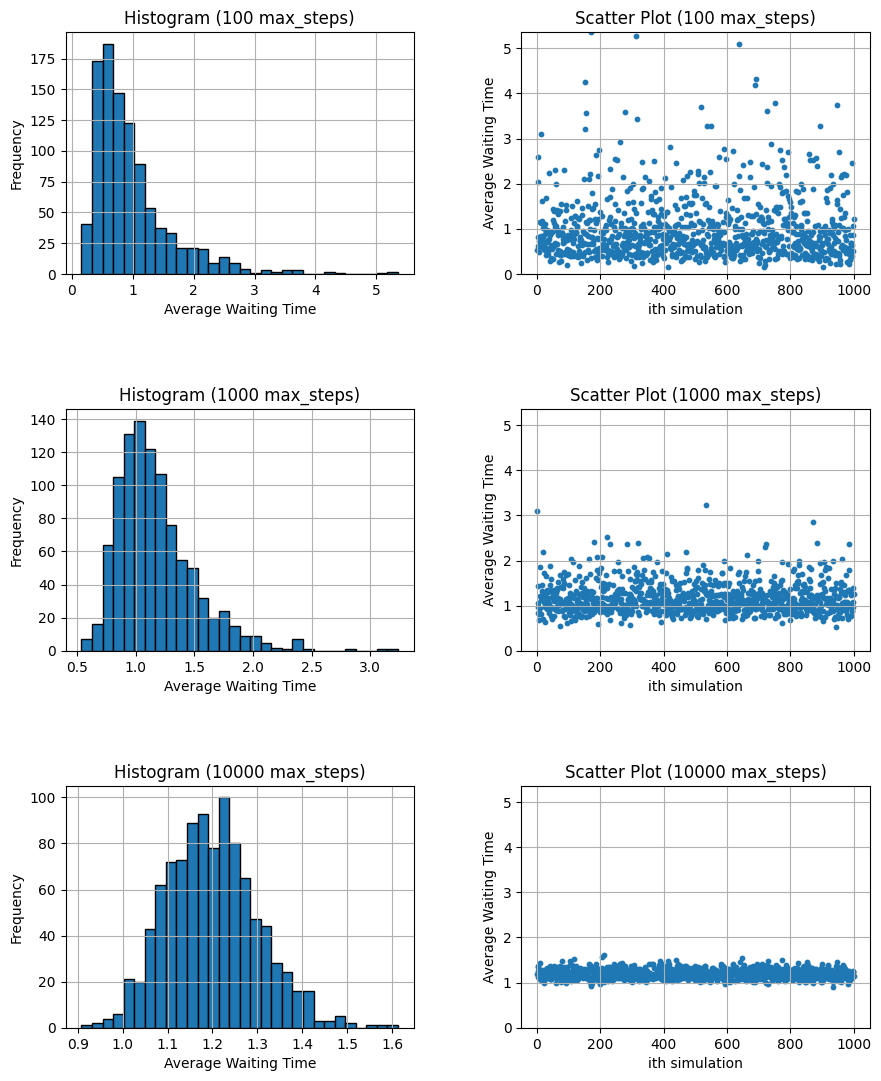

In [7]:
make_plots(1, 2, 1000, is_deterministic=True, simulation_function=simulate1)

Intervalo de Confiança (max_steps: 100): [0.23529980320585853, 0.24584909073107802]
Intervalo de Confiança (max_steps: 1000): [0.24698339123955002, 0.2506219494494773]
Intervalo de Confiança (max_steps: 10000): [0.24949094682976125, 0.2506420663089227]


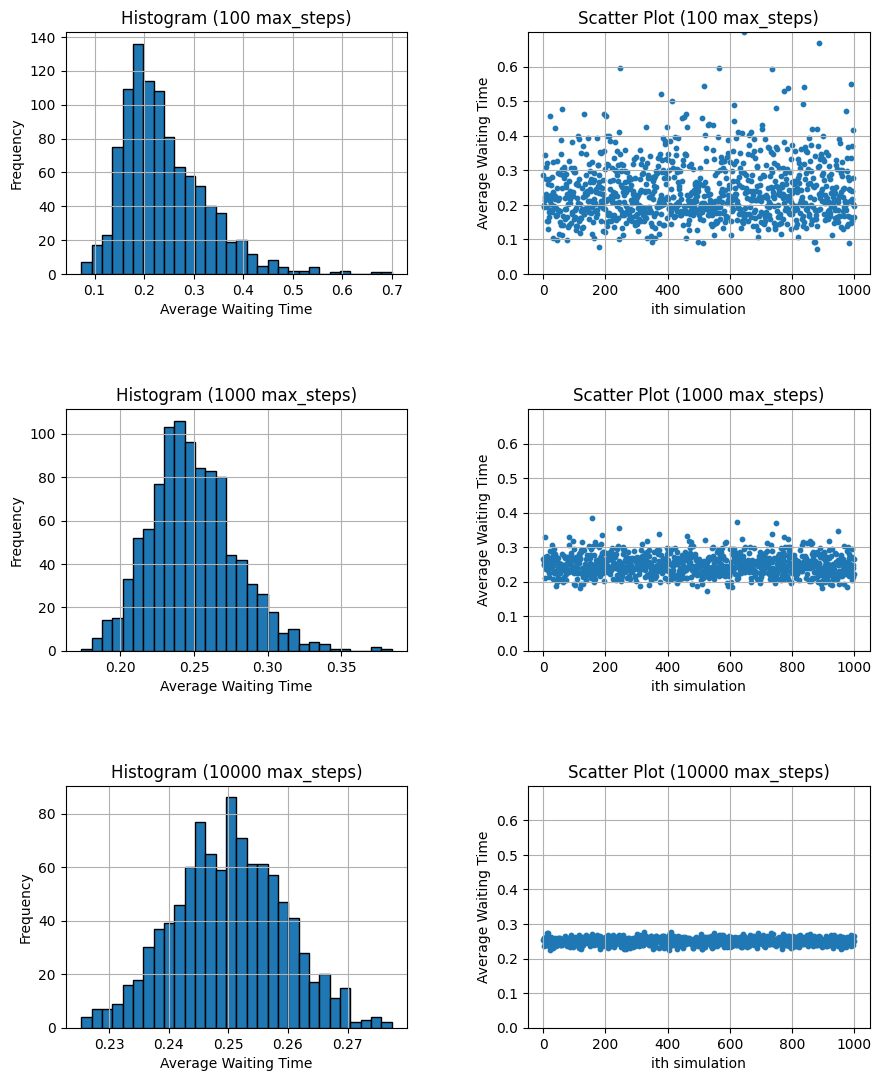

In [8]:
make_plots(1, 2, 1000, is_deterministic=True, simulation_function=simulate2)